<a href="https://colab.research.google.com/github/YUMVOLKOVA/dul_2021/blob/main/hw7/Homework7_gans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [52]:
!if [ -d dul_2021 ]; then rm -Rf dul_2021; fi
!git clone https://github.com/GrigoryBartosh/dul_2021
!pip install ./dul_2021

Cloning into 'dul_2021'...
remote: Enumerating objects: 260, done.
remote: Counting objects: 100% (97/97), done.
remote: Compressing objects: 100% (48/48), done.
remote: Total 260 (delta 61), reused 49 (delta 49), pack-reused 163
Receiving objects: 100% (260/260), 53.29 MiB | 27.00 MiB/s, done.
Resolving deltas: 100% (118/118), done.
Processing ./dul_2021
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for dul-2021: filename=dul_2021-0.1.0-py3-none-any.whl size=22409 sha256=fe9474220f8bba69beefed3aab1386d3189ad82c47f9edf7abc5b99dd9bcdfc3
  Stored in directory: /tmp/pip-ephem-wheel-cache-njaise_y/wheels/55/59/29/0fb1c635652157734

In [53]:
from dul_2021.utils.hw7_utils import *

In [54]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Question 1: GANs on CIFAR-10

In this exercise, you will train GANs on CIFAR-10. Execute the cell below to visualize the dataset. 

Files already downloaded and verified


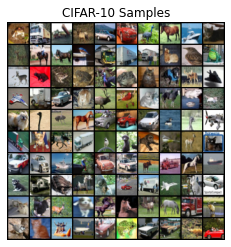

In [55]:
visualize_q1_data()

 We'll use the CIFAR-10 architecture from the [SN-GAN paper](https://arxiv.org/pdf/1802.05957.pdf), with $z \in \mathbb R ^{128}$, with $z \sim \mathcal N (0, I_{128})$. Instead of upsampling via transposed convolutions and downsampling via pooling or striding, we'll use these DepthToSpace and SpaceToDepth methods for changing the spatial configuration of our hidden states. 

```
class DepthToSpace(nn.Module):
    def __init__(self, block_size):
        super().__init__()
        self.block_size = block_size
        self.block_size_sq = block_size * block_size

    def forward(self, input):
        output = input.permute(0, 2, 3, 1)
        (batch_size, d_height, d_width, d_depth) = output.size()
        s_depth = int(d_depth / self.block_size_sq)
        s_width = int(d_width * self.block_size)
        s_height = int(d_height * self.block_size)
        t_1 = output.reshape(batch_size, d_height, d_width, self.block_size_sq, s_depth)
        spl = t_1.split(self.block_size, 3)
        stack = [t_t.reshape(batch_size, d_height, s_width, s_depth) for t_t in spl]
        output = torch.stack(stack, 0).transpose(0, 1).permute(0, 2, 1, 3, 4).reshape(batch_size, s_height, s_width,
                                                                                      s_depth)
        output = output.permute(0, 3, 1, 2)
        return output


class SpaceToDepth(nn.Module):
    def __init__(self, block_size):
        super().__init__()
        self.block_size = block_size
        self.block_size_sq = block_size * block_size

    def forward(self, input):
        output = input.permute(0, 2, 3, 1)
        (batch_size, s_height, s_width, s_depth) = output.size()
        d_depth = s_depth * self.block_size_sq
        d_width = int(s_width / self.block_size)
        d_height = int(s_height / self.block_size)
        t_1 = output.split(self.block_size, 2)
        stack = [t_t.reshape(batch_size, d_height, d_depth) for t_t in t_1]
        output = torch.stack(stack, 1)
        output = output.permute(0, 2, 1, 3)
        output = output.permute(0, 3, 1, 2)
        return output

# Spatial Upsampling with Nearest Neighbors
Upsample_Conv2d(in_dim, out_dim, kernel_size=(3, 3), stride=1, padding=1):
    x = torch.cat([x, x, x, x], dim=1)
    DepthToSpace(block_size=2)
    Conv2d(in_dim, out_dim, kernel_size, stride=stride, padding=padding)


# Spatial Downsampling with Spatial Mean Pooling
Downsample_Conv2d(in_dim, out_dim, kernel_size=(3, 3), stride=1, padding=1):
        SpaceToDepth(2)
        torch.sum(x.chunk(4, dim=1)) / 4.0
        nn.Conv2d(in_dim, out_dim, kernel_size,
                              stride=stride, padding=padding, bias=bias)
```

Here's pseudocode for how we'll implement a ResBlockUp, used in the generator:

```
ResnetBlockUp(x, in_dim, kernel_size=(3, 3), n_filters=256):
    _x = x
    _x = nn.BatchNorm2d(in_dim)(_x)
    _x = nn.ReLU()(_x)
    _x = nn.Conv2d(in_dim, n_filters, kernel_size, padding=1)(_x)
    _x = nn.BatchNorm2d(n_filters)(_x)
    _x = nn.ReLU()(_x)
    residual = Upsample_Conv2d(n_filters, n_filters, kernel_size, padding=1)(_x)
    shortcut = Upsample_Conv2d(in_dim, n_filters, kernel_size=(1, 1), padding=0)(x)
    return residual + shortcut
```
The ResBlockDown module is similar, except it uses Downsample_Conv2d and omits the BatchNorm.

Finally, here's the architecture for the generator:
```
def Generator(*, n_samples=1024, n_filters=128):
    z = Normal(0, 1)([n_samples, 128])
    nn.Linear(128, 4*4*256)
    reshape output of linear layer
    ResnetBlockUp(in_dim=256, n_filters=n_filters),
    ResnetBlockUp(in_dim=n_filters, n_filters=n_filters),
    ResnetBlockUp(in_dim=n_filters, n_filters=n_filters),
    nn.BatchNorm2d(n_filters),
    nn.ReLU(),
    nn.Conv2d(n_filters, 3, kernel_size=(3, 3), padding=1),
    nn.Tanh()
```
Again, the discriminator has the same architecture, except with ResnetBlockDown and no BatchNorm.

**Hyperparameters**

We'll implement [WGAN-GP](https://arxiv.org/abs/1704.00028), which uses a gradient penalty to regularize the discriminator. Use the Adam optimizer with $\alpha = 2e-4$, $\beta_1 = 0$, $\beta_2 = 0.9$, $\lambda = 10$, $n_{critic} = 5$. Use a batch size of 256 and n_filters=128 within the ResBlocks. Train for at least 25000 gradient steps, with the learning rate linearly annealed to 0 over training. 

**You will provide the following deliverables**
1. Inception score (CIFAR-10 version) of the final model. We provide a utility that will automatically do this for you.
2. Discriminator loss across training
3. 100 samples. 

## Solution

In [91]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.distributions import Normal
from torch.utils.data import DataLoader
import tqdm.notebook as tq
import numpy as np

from torch.autograd import grad
from torch.optim import Adam
from torch.optim.lr_scheduler import LambdaLR

In [57]:
class DepthToSpace(nn.Module):
    def __init__(self, block_size):
        super().__init__()
        self.block_size = block_size
        self.block_size_sq = block_size * block_size

    def forward(self, input):
        output = input.permute(0, 2, 3, 1)
        (batch_size, d_height, d_width, d_depth) = output.size()
        s_depth = int(d_depth / self.block_size_sq)
        s_width = int(d_width * self.block_size)
        s_height = int(d_height * self.block_size)
        t_1 = output.reshape(batch_size, d_height, d_width, self.block_size_sq, s_depth)
        spl = t_1.split(self.block_size, 3)
        stack = [t_t.reshape(batch_size, d_height, s_width, s_depth) for t_t in spl]
        output = torch.stack(stack, 0).transpose(0, 1).permute(0, 2, 1, 3, 4).reshape(batch_size, s_height, s_width, s_depth)
        output = output.permute(0, 3, 1, 2)
        return output

class SpaceToDepth(nn.Module):
    def __init__(self, block_size):
        super().__init__()
        self.block_size = block_size
        self.block_size_sq = block_size * block_size

    def forward(self, input):
        output = input.permute(0, 2, 3, 1)
        (batch_size, s_height, s_width, s_depth) = output.size()
        d_depth = s_depth * self.block_size_sq
        d_width = int(s_width / self.block_size)
        d_height = int(s_height / self.block_size)
        t_1 = output.split(self.block_size, 2)
        stack = [t_t.reshape(batch_size, d_height, d_depth) for t_t in t_1]
        output = torch.stack(stack, 1)
        output = output.permute(0, 2, 1, 3)
        output = output.permute(0, 3, 1, 2)
        return output

In [58]:
# Spatial Upsampling with Nearest Neighbors
class Upsample_Conv2d(nn.Module):
  def __init__(self, in_dim, out_dim, kernel_size=(3, 3), stride=1, padding=1):
    super().__init__()
    self.in_dim = in_dim
    self.out_dim = out_dim
    self.kernel_size = kernel_size
    self.stride = stride
    self.padding = padding
    self.dts = DepthToSpace(block_size=2)
    self.conv2d = nn.Conv2d(self.in_dim, self.out_dim, 
                         self.kernel_size, stride=self.stride, 
                         padding=self.padding)
  def forward(self, x):
    x = torch.cat([x, x, x, x], dim=1)
    return self.conv2d(self.dts(x))

# Spatial Downsampling with Spatial Mean Pooling
class Downsample_Conv2d(nn.Module):
  def __init__(self, in_dim, out_dim, kernel_size=(3, 3), stride=1, padding=1, bias=True):
    super().__init__()
    self.in_dim = in_dim
    self.out_dim = out_dim
    self.kernel_size = kernel_size
    self.stride = stride
    self.padding = padding
    self.std = SpaceToDepth(block_size=2)
    self.bias = bias
    self.conv2d = nn.Conv2d(self.in_dim, self.out_dim, 
                         self.kernel_size, stride=self.stride, 
                         padding=self.padding)    

  def forward(self, x):
    x = self.std(x)
    x = sum(x.chunk(4, dim=1)) / 4.0
    return self.conv2d(x)


In [59]:
class ResnetBlockUp(nn.Module):
  def __init__(self, in_dim, kernel_size=(3, 3), n_filters=256):
    super().__init__()
    self.in_dim = in_dim
    self.kernel_size = kernel_size
    self.n_filters = n_filters
    list_of_seq = [nn.BatchNorm2d(self.in_dim),
                   nn.ReLU(),
                   nn.Conv2d(self.in_dim, 
                             self.n_filters, 
                             self.kernel_size, padding=1),
                  nn.BatchNorm2d(self.n_filters),
                  nn.ReLU(),
                  Upsample_Conv2d(self.n_filters, 
                                  self.n_filters, 
                                  self.kernel_size, 
                                  padding=1)]
    self.residual = nn.Sequential(*list_of_seq)
    self.shortcut = Upsample_Conv2d(self.in_dim, 
                                    self.n_filters,
                                    kernel_size=(1, 1), 
                                    padding=0)
  def forward(self, data):
    residual = self.residual(data)
    shortcut = self.shortcut(data)
    return residual + shortcut



In [60]:
# The ResBlockDown module is similar, except it uses Downsample_Conv2d and omits the BatchNorm.
class ResnetBlockDown(nn.Module):
  def __init__(self, in_dim, kernel_size=(3, 3), n_filters=256):
    super().__init__()
    self.in_dim = in_dim
    self.kernel_size = kernel_size
    self.n_filters = n_filters
    list_of_seq = [nn.ReLU(),
                   nn.Conv2d(self.in_dim, 
                             self.n_filters, 
                             self.kernel_size, padding=1),
                  nn.ReLU(),
                  Downsample_Conv2d(self.n_filters, 
                                  self.n_filters, 
                                  self.kernel_size, 
                                  padding=1)]
    self.residual = nn.Sequential(*list_of_seq)
    self.shortcut = Downsample_Conv2d(self.in_dim, 
                                    self.n_filters,
                                    kernel_size=(1, 1), 
                                    padding=0)
  def forward(self, data):
    residual = self.residual(data)
    shortcut = self.shortcut(data)
    return residual + shortcut

In [61]:
class Generator(nn.Module):
  def __init__(self, n_filters=128, kernel=(3,3), padding=1):
    super().__init__()
    self.z_norm = Normal(torch.tensor(0, dtype=torch.float32, device=device), 
                         torch.tensor(1, dtype=torch.float32, device=device))
    self.linaer = nn.Linear(128, 4 * 4 * 256)
    self.n_filters = n_filters
    self.kernel = kernel
    self.padding = padding
    self.seq = [ResnetBlockUp(in_dim=256, n_filters=self.n_filters),
                ResnetBlockUp(in_dim=self.n_filters, n_filters=self.n_filters),
                ResnetBlockUp(in_dim=self.n_filters, n_filters=self.n_filters),
                nn.BatchNorm2d(self.n_filters),
                nn.ReLU(),
                nn.Conv2d(self.n_filters, 3, kernel_size=self.kernel, padding=self.padding),
                nn.Tanh()]
    self.generate = nn.Sequential(*self.seq)

  def forward(self, data):
    data = self.linaer(data)
    #reshape output of linear layer
    return self.generate(data.reshape(-1, 256, 4, 4))

  def sample(self, n):
    z = self.z_norm.sample((n, self.n_filters))
    z = self(z)
    return z


In [62]:
class Discriminator(nn.Module):
  def __init__(self, n_filters=128, kernel=(3,3), padding=1):
     super().__init__()
     self.n_filters = n_filters
     self.kernel = kernel
     self.padding = padding
     self.list_seq = [ResnetBlockDown(3, n_filters=self.n_filters),
                      ResnetBlockDown(self.n_filters, n_filters=self.n_filters),
                      ResnetBlockDown(self.n_filters, n_filters=256),
                      nn.ReLU(),
                      nn.Conv2d(256, 
                                3, 
                                kernel_size=self.kernel, 
                                padding=self.padding)]
     self.seq = nn.Sequential(*self.list_seq)
     self.linear =  nn.Linear(3 * 4 * 4, 1)

  def forward(self, data):
    data = self.seq(data)
    data = data.reshape(-1, 3 * 4 * 4)
    data = self.linear(data)
    return data


In [63]:
class GAN(nn.Module):
  def __init__(self, n_filters=128):
    super().__init__()
    self.n_filters = n_filters
    self.generator = Generator(n_filters=self.n_filters)
    self.discriminator = Discriminator(n_filters=self.n_filters)

  def r_f_interpol(self, real_img, fake_img):
    e = torch.rand((real_img.shape[0], 1, 1, 1), device=device)
    interpol = real_img * e + fake_img * (1 - e)
    return interpol

  def G_loss(self, fake_img):
    return (-self.discriminator(fake_img)).mean()
  
  def D_loss(self, real_img, fake_img, lambd):
    d_about_real = self.discriminator(real_img)
    d_about_fake = self.discriminator(fake_img)
    d_loss = d_about_fake - d_about_real
    d_loss_mean = d_loss.mean()

    interpol = self.r_f_interpol(real_img, fake_img)
    d_about_interpol = self.discriminator(interpol)
    ones = torch.ones_like(d_about_interpol)
    gradient = grad(d_about_interpol, interpol, grad_outputs=ones, create_graph=True)
    gradient = torch.norm(gradient[0].reshape(real_img.shape[0], -1), 1)
    penalty = (gradient - 1) ** 2
    penalty_mean = penalty.mean()
    final_loss = penalty_mean * lambd + d_loss_mean
    return final_loss

  def fit(self, dataloader, alpha, betas, lambd, n_critic, grad_steps):
    epochs = 10

    G_optim = Adam(self.generator.parameters(), lr=alpha, betas=betas)
    G_scheduler = LambdaLR(G_optim, lambda epoch: (epochs - epoch) / epochs, last_epoch=-1)

    D_optim = Adam(self.discriminator.parameters(), lr=alpha, betas=betas)
    D_scheduler = LambdaLR(D_optim, lambda epoch: (epochs - epoch) / epochs, last_epoch=-1)

    G_losses, D_losses = [], []
    count = 0

    for epoch in tq.tqdm(range(epochs)):
      for batch in dataloader:
        real_img = batch.to(device)
        fake_img = self.generator.sample(batch.shape[0])
        discriminator_loss = self.D_loss(real_img, fake_img, lambd)
        D_optim.zero_grad()
        discriminator_loss.backward()
        D_optim.step()
        D_losses.append(discriminator_loss.item())

        if count % n_critic == 0:
          fake_img = self.generator.sample(batch.shape[0])
          generator_loss = self.G_loss(fake_img)
          G_optim.zero_grad()
          generator_loss.backward()
          G_optim.step()
          G_losses.append(generator_loss.item())
          D_scheduler.step()
          G_scheduler.step()
        count += 1
        
    G_losses, D_losses = np.array(G_losses), np.array(D_losses)
    return G_losses, D_losses
  
  def sample(self, n):
    with torch.no_grad():
      self.generator.eval()
      samples = self.generator.sample(n)
      self.generator.train()
      samples = samples * 0.5 + 0.5
      samples = samples.cpu().numpy()
      samples = samples.transpose(0, 2, 3, 1)
    return samples

Use the Adam optimizer with $\alpha = 2e-4$, $\beta_1 = 0$, $\beta_2 = 0.9$, $\lambda = 10$, $n_{critic} = 5$. Use a batch size of 256 and n_filters=128 within the ResBlocks. Train for at least 25000 gradient steps, with the learning rate linearly annealed to 0 over training. 

In [64]:
params = {'alpha': 2e-4,
          'beta_1': 0,
          'beta_2': 0.9,
          'lambda': 10,
          'n_critic': 5,
          'batch_size': 256,
          'n_filters': 128,
          'grad_steps': 1000,
          'n': 1000}

In [65]:
def q1(train_data):
    """
    train_data: An (n_train, 3, 32, 32) numpy array of CIFAR-10 images with values in [0, 1]

    Returns
    - a (# of training iterations,) numpy array of WGAN critic train losses evaluated every minibatch
    - a (1000, 32, 32, 3) numpy array of samples from your model in [0, 1]. 
        The first 100 will be displayed, and the rest will be used to calculate the Inception score. 
    """

    """ YOUR CODE HERE """
    train = 2 * (torch.as_tensor(train_data, dtype=torch.float32) - 0.5)
    dataloader = DataLoader(train, batch_size=params['batch_size'], shuffle=True, pin_memory=True)
    model = GAN(params['n_filters'])
    model = model.to(device)

    G_losses, D_losses = model.fit(dataloader=dataloader, 
                                   alpha=params['alpha'], 
                                   betas=(params['beta_1'],params['beta_2']), 
                                   lambd=params['lambda'], 
                                   n_critic=params['n_critic'], 
                                   grad_steps=params['grad_steps'])
    samples = model.sample(params['n'])
    return D_losses, samples


## Results

Files already downloaded and verified


  0%|          | 0/10 [00:00<?, ?it/s]

..........Inception score: 1.4447747


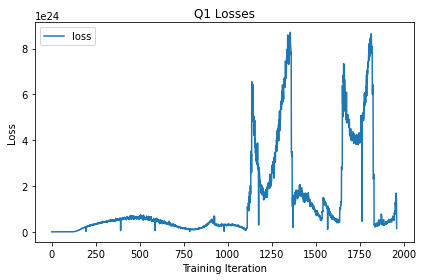

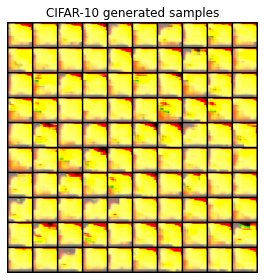

In [66]:
q1_save_results(q1)

# Question 2: Representation Learning with BiGAN on MNIST

In this part, we train a BiGAN on the MNIST dataset. Execute the cell below to visualize the dataset.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


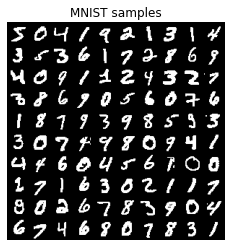

In [67]:
visualize_q2_data()

In BiGAN, in addition to training a generator $G$ and a discriminator $D$, we train an encoder $E$ that maps from real images $x$ to latent codes $z$. The discriminator now must learn to jointly identify fake $z$, fake $x$, and paired $(x, z)$ that don't belong together. In the original [BiGAN paper](https://arxiv.org/pdf/1605.09782.pdf), they prove that the optimal $E$ learns to invert the generative mapping $G: z \rightarrow x$. Our overall minimax term is now
$$V(D, E, G) = \mathbb{E}_{x \sim p_x}[\mathbb{E}_{z \sim p_E(\cdot | x)}[\log D(x, z)]] + \mathbb{E}_{z \sim p_z}[\mathbb{E}_{x \sim p_G(\cdot | z)}[\log (1 - D(x, z))]]$$

**Architecture**

We will closely follow the MNIST architecture outlined in the original BiGAN paper, Appendix C.1, with one modification: instead of having $z \sim \text{Uniform}[-1, 1]$, we use $z \sim \mathcal N (0, 1)$ with $z \in \mathbb R ^{50}$. 

**Hyperparameters**

We make several modifications to what is listed in the BiGAN paper. We apply $l_2$ weight decay to all weights and decay the step size $\alpha$ linearly to 0 over the course of training. Weights are initialized via the default PyTorch manner. We recommend training for at least 100 epochs -- this part is much less computationally expensive than previous homeworks. 

**Reconstructions**

You should take the first 20 images from the MNIST training set and then display the reconstructions $x_{recon} = G(E(x))$. It's ok if your reconstructions are somewhat lossy; ours are too. We will provide a utility to show these. 

**Testing the representation**

We want to see how good a linear classifier $L$ we can learn such that 
$$y \approx L(E(x))$$
where $y$ is the appropriate label. Fix $E$ and learn a weight matrix $W$ such that your linear classifier is composed of passing $x$ through $E$, then multiplying by $W$, then applying a softmax nonlinearity. Train this via gradient descent with the cross-entropy loss. 

As a baseline, randomly initialize another network $E_{random}$ with the same architecture, fix its weights, and train a linear classifier on top, as done in the previous part.


**You will provide the following deliverables**
1. Plot of the minimax loss term. 
2. 100 samples from the BiGAN
3. A comparison of MNIST images $x$ with their reconstructions $G(E(x))$.
4. Test loss plot for the linear classifier trained on the pretrained encoder, and a randomly initialized encoder. 
5. Final test losses for the two linear classifiers. 

**Feel free to train the networks separately, save the necessary information, and simply use our function to generate the appropriate figures.**


In [103]:
class Generator(nn.Module):
  def __init__(self, input, output):
    super().__init__()
    self.input = input
    self.output = output
    self.inner = 1024
    self.seq = [nn.Linear(self.input, self.inner),
                nn.ReLU(),
                nn.Linear(self.inner, self.inner),
                nn.BatchNorm1d(self.inner, affine=False),
                nn.ReLU(),
                nn.Linear(self.inner, self.output),
                nn.Tanh()]
    self.model = nn.Sequential(*self.seq)

  def forward(self, data):
    data = self.model(data)
    data = data.reshape(data.shape[0], 1, 28, 28)
    return data

class Discriminator(nn.Module):
  def __init__(self, z, data):
    super().__init__()
    self.inner = 1024
    self.input = z + data
    self.const_leaky = 0.2
    self.seq = [nn.Linear(self.input, self.inner),
                nn.LeakyReLU(self.const_leaky),
                nn.Linear(self.inner, self.inner),
                nn.BatchNorm1d(self.inner, affine=False),
                nn.LeakyReLU(self.const_leaky),
                nn.Linear(self.inner, 1),
                nn.Sigmoid()]
    self.model = nn.Sequential(*self.seq)

  def forward(self, z, data):
    data = torch.cat((z, data), 1)
    data = self.model(data)
    return data

class Encoder(nn.Module):
  def __init__(self, input, output):
    super().__init__()
    self.input = input
    self.output = output
    self.inner = 1024
    self.const_leaky = 0.2
    self.seq = [nn.Linear(self.input, self.inner),
                nn.LeakyReLU(self.const_leaky),
                nn.Linear(self.inner, self.inner),
                nn.BatchNorm1d(self.inner, affine=False),
                nn.LeakyReLU(self.const_leaky),
                nn.Linear(self.inner, self.output)]
    self.model = nn.Sequential(*self.seq)

  def forward(self, data):
    size = data.shape[0]
    data = data.view(size, -1)
    data = self.model(data)
    return data

def D_loss(data, dim, E, G, D):
  size = data.shape[0]
  fake_z = torch.normal(torch.zeros(size, dim), torch.ones(size, dim)).to(device)
  real_z = E(data).reshape(size, dim)

  real_img = data.view(size, -1)
  fake_img = G(fake_z).reshape(size, -1)

  loss = ((D(real_z, real_img)).log().mean() + (1 - D(fake_z, fake_img)).log().mean()) * (-0.5)
  return loss



## Solution

In [104]:
params = {'epochs': 30,
          'batch_size': 128,
          'dimention': 50,
          'data_dim': 784,
          'lr': [2e-4, 1e-3],
          'beta_1': 0.5,
          'beta_2': 0.999,
          'decay': 2.5e-5,
          'n': 100}

In [105]:
def q2(train_data, test_data):
    """
    train_data: A PyTorch dataset that contains (n_train, 28, 28) MNIST digits, normalized to [-1, 1]
                Documentation can be found at torchvision.datasets.MNIST
    test_data: A PyTorch dataset that contains (n_test, 28, 28) MNIST digits, normalized to [-1, 1]
                Documentation can be found at torchvision.datasets.MNIST

    Returns
    - a (# of training iterations,) numpy array of BiGAN minimax losses evaluated every minibatch
    - a (100, 28, 28, 1) numpy array of BiGAN samples that lie in [0, 1]
    - a (40, 28, 28, 1) numpy array of 20 real image / reconstruction pairs
    - a (# of training epochs,) numpy array of supervised cross-entropy losses on the BiGAN encoder evaluated every epoch 
    - a (# of training epochs,) numpy array of supervised cross-entropy losses on a random encoder evaluated every epoch 
    """

    """ YOUR CODE HERE """
    G = Generator(input=params['dimention'], 
                  output=params['data_dim']).to(device)
    D = Discriminator(z=params['dimention'], 
                      data=params['data_dim']).to(device)
    E = Encoder(input=params['data_dim'], 
                output=params['dimention']).to(device)
    L = nn.Linear(params['dimention'], 10).to(device)

    G_optim = Adam(list(G.parameters()) + list(E.parameters()),
                   lr=params['lr'][0],
                   betas=(params['beta_1'], params['beta_2']),
                   weight_decay=params['decay'])
    G_scheduler = LambdaLR(G_optim,
                           lambda epoch: (params['epochs'] - epoch) / params['epochs'], last_epoch=-1)
    D_optim = Adam(D.parameters(),
                   lr=params['lr'][0],
                   betas=(params['beta_1'], params['beta_2']),
                   weight_decay=params['decay'])
    D_scheduler = LambdaLR(D_optim,
                           lambda epoch: (params['epochs'] - epoch) / params['epochs'], last_epoch=-1)
    
    L_optim = Adam(L.parameters(), lr=params['lr'][1])

    print('done init')

    train = DataLoader(train_data, batch_size=params['batch_size'], shuffle=True)
    test = DataLoader(test_data, batch_size=params['batch_size'], shuffle=False)

    train_loss = []
    test_score = []

    iterations = params['epochs'] // 2
    for iter in tq.tqdm(range(iterations)):
      loss_for_batch = []
      E.eval()
      L.train()

      for (data, target) in train:
        data = data.to(device)
        target = target.to(device)

        L_optim.zero_grad()
        prediction = L(E(data).detach())
        entropy = F.cross_entropy(prediction, target)
        entropy.backward()
        L_optim.step()
        loss_for_batch.append(entropy.item())
      train_loss.append(np.mean(loss_for_batch))
      E.eval()
      L.eval()

      count = 0
      acc = 0
      with torch.no_grad():
        for (data, target) in test:
          data = data.to(device)
          size = data.shape[0]
          target = target.to(device)
          prediction = torch.argmax(L(E(data)), 1)
          acc += torch.sum(prediction == target)
          count += size
      test_score.append(acc / count)
    train_loss_class, test_score_class = np.array(train_loss), np.array(test_score)
    print('done classification losses')

    train_loss, test_loss = [], []

    for epoch in tq.tqdm(range(params['epochs'])):
      loss_for_batch = []
      G.train()
      D.train()
      E.train()

      for (data, target) in train:
        data = data.to(device)
        size = data.shape[0]
        target = target.to(device)
        D_optim.zero_grad()
        discrim_loss = D_loss(data,
                              params['dimention'],
                              E, G, D)
        discrim_loss.backward()
        D_optim.step()

        G_optim.zero_grad()
        generator_loss = -1 * D_loss(data,
                              params['dimention'],
                              E, G, D)
        generator_loss.backward()
        G_optim.step()

        loss_for_batch.append(discrim_loss.item())

      G_scheduler.step()
      D_scheduler.step()
      train_loss.append(np.mean(loss_for_batch))
    train_loss_gan = np.array(train_loss)
    print('done gan loss')

    G.eval()
    with torch.no_grad():
      samples = G(2 * (torch.rand(params['n'], params['dimention']).to(device) - 0.5))
      samples = samples.reshape(-1, 1, 28, 28)
      samples = 0.5 + 0.5 * samples.detach().cpu().numpy()
    
    samples = samples.transpose(0, 2, 3, 1) * 255.0
    samples = np.clip(samples.astype(int), 0, 255)
    print('done samples')

    G.eval()
    E.eval()
    part_of_img_ = train_data.data[:20].reshape(20, 1, 28, 28)
    part_of_img_ = part_of_img_ / 255.0
    part_of_img = 2 * torch.tensor(part_of_img_) - 1
    part_of_img = part_of_img.to(device)
    with torch.no_grad():
      reconstr = G(E(part_of_img)).reshape(-1, 1, 28, 28)
    reconstr = (0.5 + 0.5 * reconstr.detach().cpu().numpy()) * 255.0
    reconstr = np.clip(reconstr.astype(int), 0, 255)
    reconstr = np.concatenate([part_of_img_, reconstr], 0).transpose(0, 2, 3, 1)
    print('done reconstruction')

    train_loss = []
    test_score = []

    iterations = params['epochs'] // 2
    for iter in tq.tqdm(range(iterations)):
      loss_for_batch = []
      E.eval()
      L.train()

      for (data, target) in train:
        data = data.to(device)
        target = target.to(device)

        L_optim.zero_grad()
        prediction = L(E(data).detach())
        entropy = F.cross_entropy(prediction, target)
        entropy.backward()
        L_optim.step()
        loss_for_batch.append(entropy.item())
      train_loss.append(np.mean(loss_for_batch))
      E.eval()
      L.eval()

      count = 0
      acc = 0
      with torch.no_grad():
        for (data, target) in test:
          data = data.to(device)
          size = data.shape[0]
          target = target.to(device)
          prediction = torch.argmax(L(E(data)), 1)
          acc += torch.sum(prediction == target)
          count += size
      test_score.append(acc / count)
    train_loss_bigan, test_score_bigan = np.array(train_loss), np.array(test_score)

    return train_loss_gan, samples, reconstr, train_loss_bigan, train_loss_class


## Results

done init


  0%|          | 0/15 [00:00<?, ?it/s]

done classification losses


  0%|          | 0/30 [00:00<?, ?it/s]

done gan loss
done samples
done reconstruction


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:130: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


  0%|          | 0/15 [00:00<?, ?it/s]

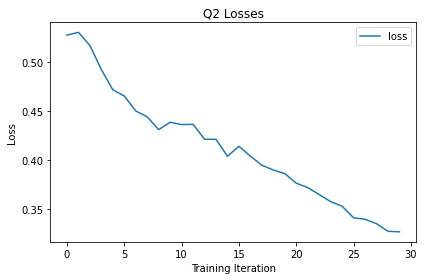

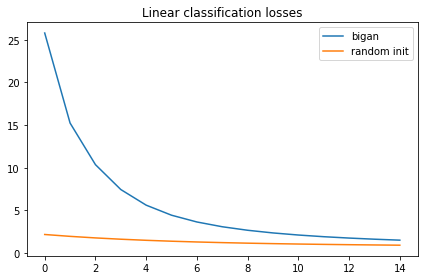

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


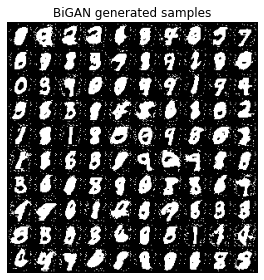

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


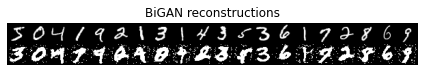

BiGAN final linear classification loss: 1.5132831821817834
Random encoder linear classification loss: 0.924175923948349


In [106]:
q2_save_results(q2)

# Bonus 5: CycleGAN
In this question, you'll train a CycleGAN model to learn to translate between two different image domains, without any paired data. Execute the following cell to visualize our two datasets: MNIST and Colored MNIST. 

In [ ]:
visualize_cyclegan_datasets()

In [CycleGAN](https://arxiv.org/pdf/1703.10593.pdf), the goal is to learn functions $F$ and $G$ that can transform images from $X \rightarrow Y$ and vice-versa. This is an unconstrained problem, so we additionally enforce the *cycle-consistency* property, where we want 
$$x \approx G(F(x))$$
and  
$$y \approx F(G(x))$$
This loss function encourages $F$ and $G$ to approximately invert each other. In addition to this cycle-consistency loss, we also have a standard GAN loss such that $F(x)$ and $G(y)$ look like real images from the other domain. 

Since this is a bonus question, we won't do much hand-holding. We recommend reading through the original paper to get a sense of what architectures and hyperparameters are useful. Note that our datasets are fairly simple, so you won't need excessively large models. 

**You will report the following deliverables**
1. A set of images showing real MNIST digits, transformations of those images into Colored MNIST digits, and reconstructions back into the greyscale domain. 
2. A set of images showing real Colored MNIST digits, transformations of those images, and reconstructions. 

## Solution

In [ ]:
def b5(mnist_data, cmnist_data):
    """
    mnist_data: An (60000, 1, 28, 28) numpy array of black and white images with values in [0, 1]
    cmnist_data: An (60000, 3, 28, 28) numpy array of colored images with values in [0, 1]

    Returns
    - a (20, 28, 28, 1) numpy array of real MNIST digits, in [0, 1]
    - a (20, 28, 28, 3) numpy array of translated Colored MNIST digits, in [0, 1]
    - a (20, 28, 28, 1) numpy array of reconstructed MNIST digits, in [0, 1]

    - a (20, 28, 28, 3) numpy array of real Colored MNIST digits, in [0, 1]
    - a (20, 28, 28, 1) numpy array of translated MNIST digits, in [0, 1]
    - a (20, 28, 28, 3) numpy array of reconstructed Colored MNIST digits, in [0, 1]
    """
    """ YOUR CODE HERE """

## Results

In [ ]:
b5_save_results(b5)